In [2]:
#import packages
import os
import time as t
import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

In [8]:
#set selenium options
options = Options()
options.add_argument("--disable-notification")
options.add_argument('--start-maximized')
options.add_argument('headless')

In [9]:
#get disease url #disease number = 955

chrome = webdriver.Chrome('chromedriver.exe', options = options)
chrome.get('https://www.mycancergenome.org/content/disease/')
t.sleep(5)

i = 500
while True:

    diseases = chrome.find_elements(By.XPATH,'/html/body/div[1]/div/div/div[2]/div[4]/div[2]/div/div[1]/div')
    disease_no = len(diseases)

    #scroll down
    chrome.execute_script(f"window.scrollTo(0, {i})")
    t.sleep(2)
    try:
        chrome.find_element(By.XPATH,'/html/body/div[1]/div/div/div[2]/div[4]/div[2]/div/div[2]/button').click()
    except:
        pass
    t.sleep(1)

    i +=500

    #get url
    if disease_no >= 955:
        with open('disease_url.xls','w',encoding='utf-8') as f_output:
            f_output.write('\t'.join(['Status','Title','Genes','Drug_no','Disease_URL']) + '\n')
            for disease in diseases:
                try:
                    title = disease.find_element(By.TAG_NAME,'h5').get_attribute('title')
                    url = disease.find_element(By.TAG_NAME,'a').get_attribute('href')
                    genes = disease.find_elements(By.TAG_NAME,'p')[0].text.replace('Related Genes:','').strip().replace(', ',',')
                    drug_no = disease.find_elements(By.TAG_NAME,'p')[2].text.replace('Drugs:','').strip()
                    f_output.write('\t'.join(['Pass',title,genes,drug_no,url]) + '\n')
                except:
                    title = disease.find_element(By.TAG_NAME,'h5').get_attribute('title')
                    f_output.write('\t'.join(['Not_pass',title]) + '\n')
        break
    
t.sleep(2)
chrome.quit()
print('Complete disease URL query.')

Complete disease URL query.


In [15]:
#check all the disease urls in file
df = pd.read_csv('disease_url.xls',sep='\t')
df['Status'].value_counts()

Status
Pass    955
Name: count, dtype: int64

In [17]:
#get drug information from disease url

d = {}

chrome = webdriver.Chrome('chromedriver.exe', options = options)

with open('disease_url.xls','r',encoding='utf-8') as f_input:
    for line in f_input.readlines()[1:]:
        d[line.split('\t')[1]] = line.split('\t')[4].strip()

if 'log.txt' in os.listdir('.'):
    with open('log.txt','r') as log_input:
        complete_disease = log_input.read().strip().split('\n')
else:
    complete_disease = []

for disease in d:

    if disease not in complete_disease and disease != '':

        chrome.get(d[disease])
        t.sleep(3)

        with open('mycancergenome_therapy.xls','a',encoding='utf-8') as f_output:
            for clickable_class in chrome.find_elements(By.CLASS_NAME,'clickable'):
                if 'biomarker-directed therapies' in clickable_class.text.lower():
                    clickable_class.click()
                    t.sleep(2)
                    for about_disease_therapy in chrome.find_element(By.ID,'therapies-toggle').find_elements(By.CLASS_NAME,'about-disease-therapy-row'):
                        about_disease_therapy.click()
                        drug = about_disease_therapy.find_element(By.CLASS_NAME,'about-disease-therapy-header').text.replace('\n-','')
                        for sensitivity in about_disease_therapy.find_elements(By.CLASS_NAME,'about-disease-therapy-sensitivity-row'):
                            sensitivity_header = sensitivity.find_element(By.CLASS_NAME,'about-disease-therapy-sensitivity-header').text.replace('\n-','').replace(':','').strip()
                            for biomarker in sensitivity.find_elements(By.CLASS_NAME,'targeted-therapy-table-large-screen-container'):

                                criteria, clinical_setting, note = '.', '.', '.'
                                for tr in biomarker.find_elements(By.TAG_NAME,'tr'):
                                    for td in tr.find_elements(By.TAG_NAME,'td'):
                                        if td.text.lower().startswith('biomarker criteria'):
                                            criteria_li = [i.text for i in td.find_elements(By.CLASS_NAME,'therapy_criteria_header')]
                                            if len(criteria_li) == 1:
                                                criteria = criteria_li[0].replace('\n',' ').strip()
                                            else:
                                                criteria_parent = criteria_li[0].replace('\n',' ')
                                                for criteria_element in criteria_li[1:]:
                                                    criteria_parent = criteria_parent.replace(criteria_element.replace('\n',' '),'')
                                                criteria = criteria_parent.strip() + ' [' + ' | '.join([i.replace('\n',' ') for i in criteria_li[1:]]) + ']'
                                        elif td.text.lower().startswith('clinical setting'):
                                            clinical_setting = td.text.replace('Clinical Setting(s):','').strip()
                                        elif td.text.lower().startswith('note'):
                                            note = td.text.replace('Note:','').strip()
                                                                    
                                f_output.write('\t'.join([
                                    disease,
                                    drug,
                                    sensitivity_header,
                                    criteria,
                                    clinical_setting,
                                    note.replace('≥','more than or equal to')
                                ]) + '\n')

        with open('log.txt','a') as log_output:
            log_output.write(disease + '\n')

    else:
        pass

chrome.quit()
print('Complete drug information query.')


Complete drug information query.


In [3]:
df = pd.read_csv('mycancergenome_therapy.xls',sep='\t')
df.columns = ['Disease','Therapy','Sensitivity','Criteria','Clinical_Setting','Note']

In [22]:
df.head()

,Disease,Therapy,Sensitivity,Criteria,Clinical_Setting,Note
0,Breast Carcinoma,Ado-Trastuzumab Emtansine,Disease is predicted to be sensitive,Sample must match all of the following: HER2 P...,"Adjuvant (FDA, NCCN), Metastatic (FDA, NCCN)",Indicated (as a single agent) for the treatmen...
1,Breast Carcinoma,Ado-Trastuzumab Emtansine,Disease is predicted to be sensitive,Sample must match all of the following: HER2 P...,"Metastatic (NICE, SMC)",.
2,Breast Carcinoma,Anastrozole,Disease is predicted to be sensitive,Sample must match all of the following: Hormon...,"Adjuvant (FDA, NCCN), Metastatic (FDA, NCCN)","Indicated for HR-positive breast cancer, as ad..."
3,Breast Carcinoma,Anastrozole,Disease is predicted to be sensitive,Sample must match all of the following: Hormon...,"Adjuvant (NICE, SMC)",Please note that NICE guidance stipulates estr...
4,Breast Carcinoma,Anastrozole,Disease is predicted to be sensitive,Sample must match all of the following: Hormon...,"Adjuvant (NICE, SMC)",.


In [23]:
df.shape

(393, 6)

In [4]:
df_sensitive = df[df['Sensitivity'].str.contains('sensitive')]
df_resistant = df[df['Sensitivity'].str.contains('resistant')]

In [7]:
#numbers of therapies listed in a disease
df_sensitive_disease = df_sensitive.groupby('Disease')['Therapy'].agg('count')
df_sensitive_disease = df_sensitive_disease.reset_index()
df_sensitive_disease.columns = ['Disease','Count']
df_sensitive_disease = df_sensitive_disease.sort_values('Count',ascending=False)

df_resistant_disease = df_resistant.groupby('Disease')['Therapy'].agg('count')
df_resistant_disease = df_resistant_disease.reset_index()
df_resistant_disease.columns = ['Disease','Count']
df_resistant_disease = df_resistant_disease.sort_values('Count',ascending=False)

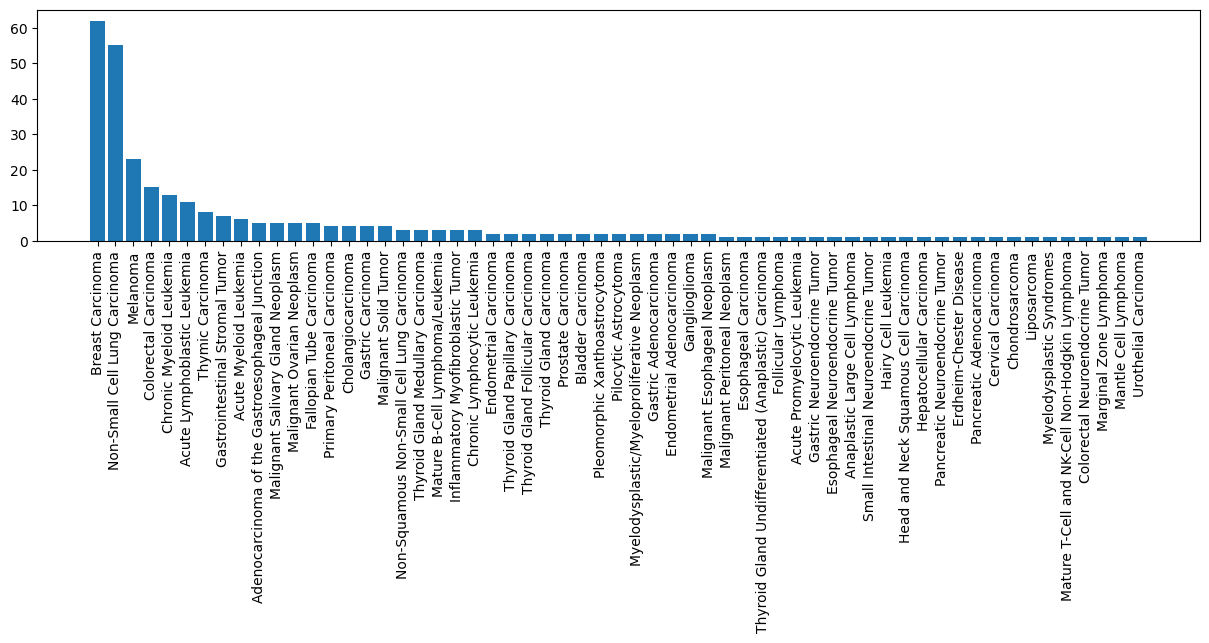

In [9]:
#number of sensitive therapy in each disease
plt.figure(figsize=(15,3))
plt.bar(df_sensitive_disease['Disease'],df_sensitive_disease['Count'])
plt.xticks(rotation=90)
plt.show()

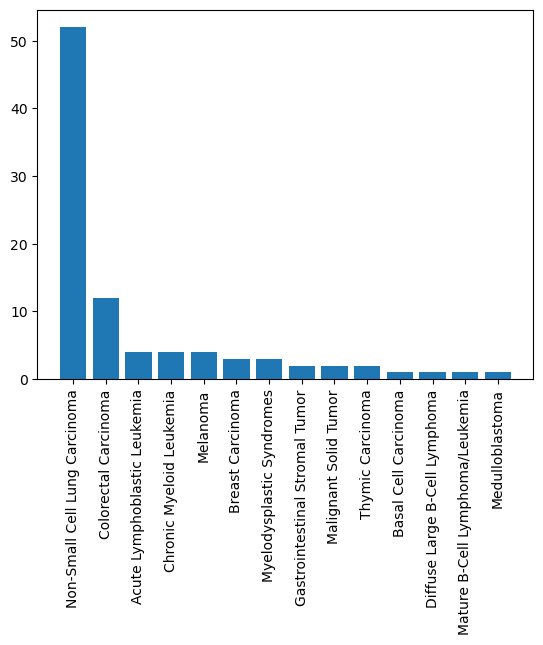

In [50]:
#number of resistant therapy in each disease
plt.bar(df_resistant_disease['Disease'],df_resistant_disease['Count'])
plt.xticks(rotation=90)
plt.show()

In [9]:
df_sensitive_EGFR = df_sensitive.loc[df['Criteria'].str.contains('EGFR')]
df_sensitive_EGFR.drop_duplicates(['Disease','Therapy']).head()

,Disease,Therapy,Sensitivity,Criteria,Clinical_Setting,Note
72,Non-Small Cell Lung Carcinoma,Afatinib,Disease is predicted to be sensitive,Sample must match one or more of the following...,"Metastatic (FDA, NCCN, ASCO)","Single agent (FDA, NCCN), or may be considered..."
85,Non-Small Cell Lung Carcinoma,Amivantamab,Disease is predicted to be sensitive,Sample must match one or more of the following...,Metastatic (FDA),Indicated for locally advanced or metastatic N...
86,Non-Small Cell Lung Carcinoma,Atezolizumab,Disease is predicted to be sensitive,Sample must match all of the following: [Sampl...,"Metastatic (FDA, NCCN)",Approved for the first-line treatment of adult...
92,Non-Small Cell Lung Carcinoma,Cemiplimab,Disease is predicted to be sensitive,Sample must match all of the following: [Sampl...,"Metastatic (FDA, NCCN)",For high expression of PD-L1 (Tumor Proportion...
103,Non-Small Cell Lung Carcinoma,Dacomitinib,Disease is predicted to be sensitive,Sample must match one or more of the following...,"Metastatic (FDA, NCCN)",.
